# FULL RESOLUTION DSM STEP BY STEP FROM SENSOR IMAGES

This notebook run step by step the full resolution pipeline, from sensor images inputs

---------
---------
### Notebook Preparation
---------


#### Imports

In [1]:
import os
import math
###
# Silent OTB info logs
os.environ['OTB_LOGGER_LEVEL']='WARNING'
import warnings
warnings.filterwarnings("ignore",category=UserWarning)
# import pretty print
import pprint 
pp = pprint.PrettyPrinter(indent=4)

# import external function for notebook
from utils import get_full_data, show_data, save_data, get_notebook_dir_path, set_up_demo_inputs

# CARS imports
from cars.applications.application import Application
from cars.applications.grid_generation import grid_correction
from cars.applications.sparse_matching import sparse_matching_tools

from cars.conf import log_conf
from cars.core import inputs, preprocessing
from cars.core.utils import safe_makedirs
from cars.orchestrator import orchestrator
from cars.core.utils import make_relative_path_absolute

import cars.pipelines.sensor_to_full_resolution_dsm.sensor_full_res_dsm_constants as sens_cst
from cars.pipelines.sensor_to_full_resolution_dsm import sensors_inputs
from cars.pipelines.sensor_to_full_resolution_dsm import dsm_output

from cars import __version__
print("CARS version used : {}".format(__version__))

CARS version used : 0.4.0


---------
---------
## Initialization
---------



### Define outputs

In [2]:
default_output_dir = os.path.join(get_notebook_dir_path(), "output_notebook")
# TODO overide if needed
output_dir = default_output_dir
print(output_dir)

/work/OT/siaa/3D/Temporary/steuxyo/CARS/REFACTO/review_mr_refacto/cars-hal/cars-0.4.0/notebooks/output_notebook


### Define inputs

In [18]:
# TODO : modify with you own data
input_dir_path = set_up_demo_inputs()

inputs_conf = {
    "sensors": {
        "left": {
            "image": os.path.join(input_dir_path, "img1.tif"),
            "geomodel": os.path.join(input_dir_path, "img1.geom"),
            "color": os.path.join(input_dir_path, "color1.tif"),
            "no_data": 0,


        },
        "right": {
            "image": os.path.join(input_dir_path, "img2.tif"),
            "geomodel": os.path.join(input_dir_path, "img2.geom"),
            "no_data": 0,
        },   
    },
    "pairing": [["left", "right"]],
    "initial_elevation": os.path.join(input_dir_path, "srtm_dir")
}

inputs = sensors_inputs.sensors_check_inputs(inputs_conf)
pp.pprint(inputs)

{   'check_inputs': False,
    'default_alt': 0,
    'epsg': None,
    'geoid': '/work/OT/siaa/3D/Temporary/steuxyo/CARS/REFACTO/review_mr_refacto/cars-hal/cars-0.4.0/cars/pipelines/sensor_to_full_resolution_dsm/../../conf/geoid/egm96.grd',
    'initial_elevation': '/work/OT/siaa/3D/Temporary/steuxyo/CARS/REFACTO/review_mr_refacto/cars-hal/cars-0.4.0/notebooks/data_notebook/srtm_dir',
    'pairing': [['left', 'right']],
    'roi': None,
    'sensors': {   'left': {   'color': '/work/OT/siaa/3D/Temporary/steuxyo/CARS/REFACTO/review_mr_refacto/cars-hal/cars-0.4.0/notebooks/data_notebook/color1.tif',
                               'geomodel': '/work/OT/siaa/3D/Temporary/steuxyo/CARS/REFACTO/review_mr_refacto/cars-hal/cars-0.4.0/notebooks/data_notebook/img1.geom',
                               'image': '/work/OT/siaa/3D/Temporary/steuxyo/CARS/REFACTO/review_mr_refacto/cars-hal/cars-0.4.0/notebooks/data_notebook/img1.tif',
                               'mask': None,
                      

##

### Initialize applications

#### GridGeneration

This application generates epipolar grids correponding to sensor pair

In [19]:
epipolar_grid_generation_application = Application("grid_generation")

#### Resampling

This application generates epipolar images 

In [20]:
resampling_application = Application("resampling")

#### SparseMatching

This application generates sparse matches of pairs

In [21]:
sparse_matching_application = Application("sparse_matching")

#### DenseMatching

This application generates dense matches of pairs

In [22]:
dense_matching_application = Application("dense_matching")

##### Use MCCNN Pandora plugin for cost matching

uncomment to use MCCNN network

In [23]:
# ! pip install pandora_plugin_mccnn
# dense_matching_application = Application("dense_matching", cfg={"method": "mccnn_sgm"})

#### Show used configuration

In [24]:
dense_matching_application.print_config()

{   'epipolar_tile_margin_in_percent': 60,
    'loader': 'pandora',
    'loader_conf': {   'input': {'nodata_left': -9999, 'nodata_right': -9999},
                       'pipeline': {   'disparity': {   'disparity_method': 'wta',
                                                        'invalid_disparity': nan},
                                       'filter': {   'filter_method': 'median',
                                                     'filter_size': 3},
                                       'matching_cost': {   'matching_cost_method': 'census',
                                                            'subpix': 1,
                                                            'window_size': 5},
                                       'optimization': {   'P1': 8,
                                                           'P2': 32,
                                                           'min_cost_paths': False,
                                                           'optimiza

#### Triangulation

This application triangulates matches, in order to get X Y Z position of each point

In [25]:
triangulation_application = Application("triangulation")

#### PointCloudFusion

This application perform the fusion of epipolar points from pairs, to a terrain point cloud

In [26]:
pc_fusion_application = Application("point_cloud_fusion")

#### PointCloudOutliersRemoving : small components

This application remove outliers points. The methode used is the small components removing

In [27]:
conf_outlier_removing_small_components = {"method": "small_components"}
pc_outlier_removing_small_comp_application = Application("point_cloud_outliers_removing", cfg=conf_outlier_removing_small_components)

#### PointCloudOutliersRemoving : statistical

This application remove outliers points. The methode used is the statistical removing

In [28]:
conf_outlier_removing_small_statistical = {"method": "statistical"}
pc_outlier_removing_stats_application = Application("point_cloud_outliers_removing", cfg=conf_outlier_removing_small_statistical)

#### PointCloudRasterization

This application performs the rasterization of a terrain point cloint.

In [29]:
conf_rasterization = { 
    "method": "simple_gaussian",
    "dsm_radius": 3,
    "sigma": 0.3
}
rasterization_application = Application("point_cloud_rasterization", cfg=conf_rasterization)

### Create orchestrator


In [30]:
orchestrator_conf = {"mode": "sequential"}
cars_orchestrator = orchestrator.Orchestrator(orchestrator_conf=orchestrator_conf, out_dir=output_dir)

---------
---------
## Run step by step from sensors to DSM
---------


### Sensors Images Generation
from inputs

In [31]:
_, sensor_image_left, sensor_image_right = sensors_inputs.generate_inputs(inputs)[0]

### Grid Generation : epipolar grid generation

In [32]:
grid_left, grid_right = epipolar_grid_generation_application.run(
    sensor_image_left,
    sensor_image_right,
    orchestrator=cars_orchestrator,
    srtm_dir=inputs[sens_cst.INITIAL_ELEVATION],
    default_alt=inputs[sens_cst.DEFAULT_ALT],
    geoid_path=inputs[sens_cst.GEOID],
)

Computing epipolar grids ...: 100% [**************************************************] (0s)


### Resampling : epipolar images generation


In [33]:
epipolar_image_left, epipolar_image_right = resampling_application.run(
    sensor_image_left,
    sensor_image_right,
    grid_left,
    grid_right,
    orchestrator=cars_orchestrator,
    margins=sparse_matching_application.get_margins()
)

### Show epipolar image

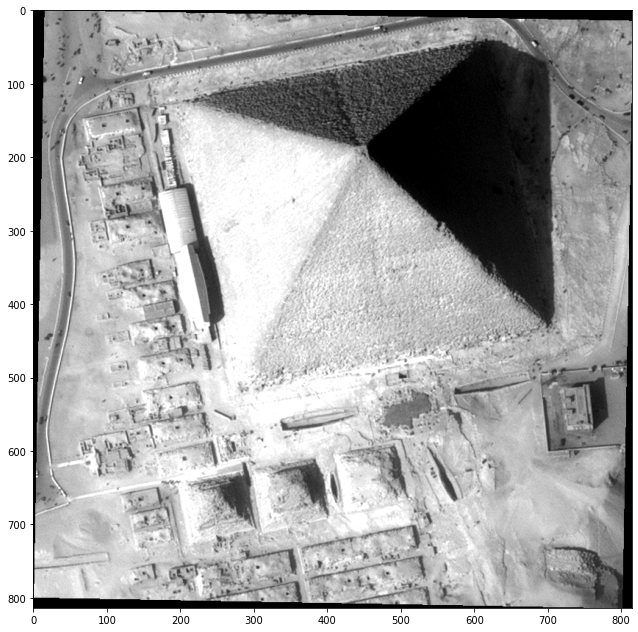

In [34]:
data_image_left = get_full_data(epipolar_image_left, "im")
show_data(data_image_left, mode="image")

###  Sparse Matching: compute sifts

In [35]:
epipolar_matches_left, _ = sparse_matching_application.run(
    epipolar_image_left,
    epipolar_image_right,
    grid_left.attributes["disp_to_alt_ratio"],
    orchestrator=cars_orchestrator
)

### Grid correction: correct epipolar grids thanks to sparse matches
Find correction to apply, and generate new right epipolar grid

Filter matches

In [36]:
matches_array = sparse_matching_application.filter_matches(epipolar_matches_left, orchestrator=cars_orchestrator)

Processing Tiles : [ epi_matches_left ] ...: 100%|██████████| 4/4 [00:00<00:00, 17943.55it/s]


Estimate grid correction

In [37]:
grid_correction_coef, corrected_matches_array,_, _, _, _ = grid_correction.estimate_right_grid_correction(matches_array, grid_right)

Correct right grid

In [38]:
corrected_grid_right = grid_correction.correct_grid(grid_right, grid_correction_coef)

#### Estimate disp min and disp max

In [39]:
dmin, dmax = sparse_matching_tools.derive_disparity_range_from_matches(
    corrected_matches_array,
    orchestrator=cars_orchestrator,
    disparity_margin=sparse_matching_application.get_disparity_margin(),
    disp_to_alt_ratio=grid_left.attributes["disp_to_alt_ratio"],
    disparity_outliers_rejection_percent=sparse_matching_application.get_disp_out_reject_percent()
)

#### Compute margins used in dense matching, with corresponding disparity min and max

In [40]:
dense_matching_margins, disp_min, disp_max = dense_matching_application.get_margins(
    grid_left, disp_min=dmin, disp_max=dmax)

###  Resampling: generate epipolar images with corrected grids, and new margins

In [41]:
new_epipolar_image_left, new_epipolar_image_right = resampling_application.run(
    sensor_image_left,
    sensor_image_right,
    grid_left,
    corrected_grid_right,
    orchestrator=cars_orchestrator,
    margins=dense_matching_margins,
    optimum_tile_size=(
        dense_matching_application.get_optimal_tile_size(
            disp_min, disp_max
        )
    ),
    add_color=True,
)

### Dense Matching: compute disparities with pandora

In [42]:
epipolar_disparity_map_left, epipolar_disparity_map_right = dense_matching_application.run(
    new_epipolar_image_left,
    new_epipolar_image_right,
    orchestrator=cars_orchestrator,
    disp_min=disp_min,
    disp_max=disp_max,
)

#### Show full disparity map

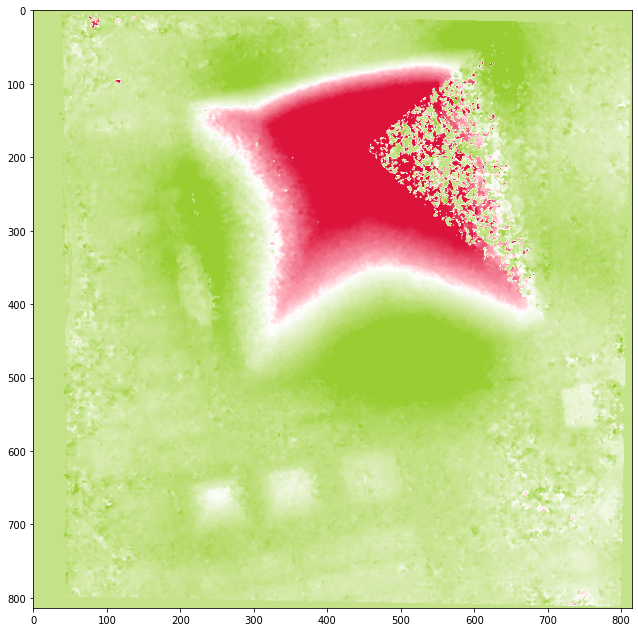

In [43]:
data_dispariy = get_full_data(epipolar_disparity_map_left, "disp")
show_data(data_dispariy)

 Compute epsg

In [44]:
epsg = preprocessing.compute_epsg(
    sensor_image_left, 
    sensor_image_right,
    grid_left,
    corrected_grid_right,
    triangulation_application.get_geometry_loader(),
    orchestrator=cars_orchestrator,
    srtm_dir=inputs[sens_cst.INITIAL_ELEVATION],
    default_alt=inputs[sens_cst.DEFAULT_ALT],
    disp_min=disp_min,
    disp_max=disp_max
)

### Triangulation : triangulate matches

In [45]:
epipolar_points_cloud_left, epipolar_points_cloud_right = triangulation_application.run(
    sensor_image_left,
    sensor_image_right,
    new_epipolar_image_left,
    new_epipolar_image_right,
    grid_left,
    corrected_grid_right,
    epipolar_disparity_map_left,
    epipolar_disparity_map_right,
    epsg,
    orchestrator=cars_orchestrator,
    uncorrected_grid_right=grid_right,
    geoid_path=inputs[sens_cst.GEOID],
    disp_min=disp_min,
    disp_max=disp_max,
)

 Compute terrain bounding box

In [46]:
current_terrain_roi_bbox = preprocessing.compute_terrain_bbox(
    inputs[sens_cst.INITIAL_ELEVATION],
    inputs[sens_cst.DEFAULT_ALT],
    inputs[sens_cst.GEOID],
    sensor_image_left,
    sensor_image_right,
    new_epipolar_image_left,
    grid_left,
    corrected_grid_right,
    epsg,
    triangulation_application.get_geometry_loader(),
    resolution=rasterization_application.get_resolution(),
    disp_min=disp_min,
    disp_max=disp_max,
    orchestrator=cars_orchestrator
)
terrain_bounds, optimal_terrain_tile_width = preprocessing.compoute_terrain_bounds(
    [current_terrain_roi_bbox],
    resolution=rasterization_application.get_resolution()
)

 (0s)
 (0s)



Transform point cloud to terrain point cloud

In [47]:
merged_points_clouds = pc_fusion_application.run(
    [epipolar_points_cloud_left],
    [epipolar_points_cloud_right],
    terrain_bounds,
    epsg,
    orchestrator=cars_orchestrator,
    margins=rasterization_application.get_margins(),
    optimal_terrain_tile_width=optimal_terrain_tile_width
)

### Point Cloud Outlier Removing : remove points with small components removing method

In [48]:
filtered_sc_merged_points_clouds = pc_outlier_removing_small_comp_application.run(
    merged_points_clouds,
    orchestrator=cars_orchestrator,
)

         

### Point Cloud Outlier Removing: remove points with statistical removing method

In [49]:
filtered_stats_merged_points_clouds = pc_outlier_removing_stats_application.run(
    filtered_sc_merged_points_clouds,
    orchestrator=cars_orchestrator,
)

### Rasterization : rasterize point cloud

In [50]:
dsm = rasterization_application.run(
    filtered_stats_merged_points_clouds,
    epsg,
    orchestrator=cars_orchestrator
)

#### Show DSM


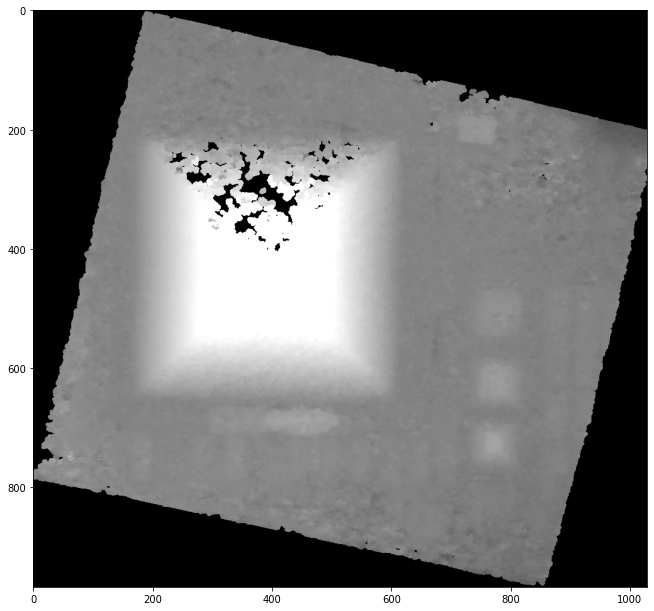

In [51]:
data_dsm = get_full_data(dsm, "hgt")
show_data(data_dsm, mode="dsm")

#### Show ortho image

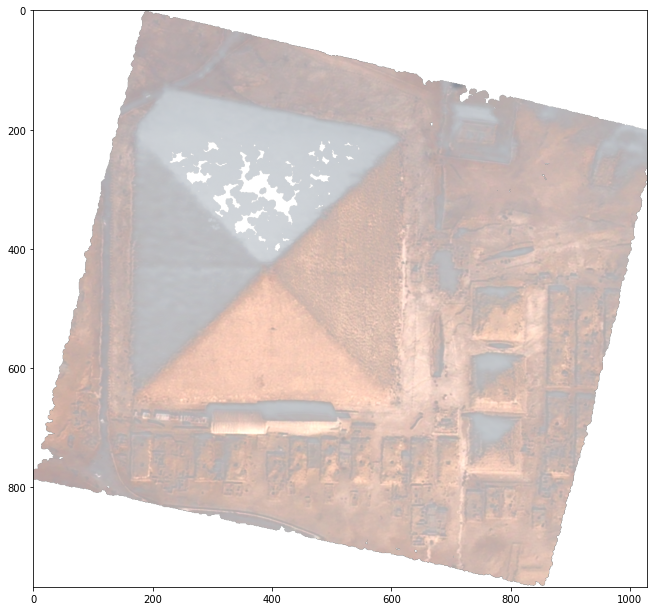

In [52]:
data_dsm = get_full_data(dsm, "img")
show_data(data_dsm, mode='image')


#### Save DSM

In [53]:
save_data(dsm, os.path.join(output_dir, "dsm.tif"), "img")